In [3]:
import numpy as np
import xarray as xr
import dask
import zarr
import pyresample as pr

import cartopy
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

### Load dataset

In [4]:
# Main disagnostic output
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')
coords = ecco.coords.to_dataset().reset_coords()

In [5]:
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_budgFw/')

In [6]:
budg = budg.reset_coords(drop=True)

In [7]:
budg

<xarray.Dataset>
Dimensions:  (face: 13, i: 90, j: 90, k: 50, time: 288)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14T12:00:00
Data variables:
    adv      (time, face, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    dif      (time, face, k, j, i) float64 dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    frc      (time, face, k, j, i) float32 dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    tnd      (time, face, k, j, i) float64 dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>

In [8]:
budg.coords['Z'] = coords.Z

#### over depth range

In [9]:
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
print(budg.Z.values)

[-5 -15 -25 -35 -45 -55 -65 -75.005 -85.025 -95.095 -105.31 -115.87
 -127.15 -139.74 -154.47 -172.4 -194.735 -222.71 -257.47 -299.93 -350.68
 -409.93 -477.47 -552.71 -634.735 -722.4 -814.47 -909.74 -1007.16 -1105.91
 -1205.54 -1306.2 -1409.15 -1517.09 -1634.18 -1765.14 -1914.15 -2084.03
 -2276.23 -2491.25 -2729.25 -2990.25 -3274.25 -3581.25 -3911.25 -4264.25
 -4640.25 -5039.25 -5461.25 -5906.25]


**Depth of integration**:
- 50 m: Deepest depth layer at 45 m (`z_lower`: 50)
- 100 m: Deepest depth layer at 95.095 m (`z_lower`: 100)
- 300 m: Deepest depth layer at 299.93 m (`z_lower`: 300)
- 700 m: Deepest depth layer at 634.735 m (`z_lower`: 700)
- 2000 m: Deepest depth layer at 1993.62 m (`z_lower`: 2000)
- full-depth: Deepest depth layer at 5906.25 m (`z_lower`: 6000)

In [10]:
budg = budg.swap_dims({'k':'Z'})

z_lower = 6000
print('Deepest depth layer at',budg.sel(Z=slice(0,-z_lower)).Z[-1].values,' m')

Deepest depth layer at -5906.25  m


In [11]:
# Create mask to ensure all terms have the depth range in defined values
mask = budg.tnd + budg.frc + budg.adv + budg.dif

In [12]:
budg_sumZ = (budg*(mask/mask)).sel(Z=slice(0,-z_lower)).sum('Z')

In [13]:
# Extract LLC coordinates
lons_1d = coords.XC.values.reshape(np.product(coords.XC.values.shape))
lats_1d = coords.YC.values.reshape(np.product(coords.YC.values.shape))

# Define original grid
orig_grid = pr.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

# Spatial resolution
# Note: 1/4 degree is the default resolution in lon and lat to interpolate
dx = 0.25
dy = 0.25

# Longitudes latitudes to which we will we interpolate
lon_tmp = np.linspace(-180., 180., int(360/dx))
lat_tmp = np.linspace(-89.5, 89.5, int(90/dy))

# Define the lat lon points of the two parts.
new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
new_grid  = pr.geometry.GridDefinition(lons=new_grid_lon, lats=new_grid_lat)

In [15]:
tnd9805 = budg_sumZ.tnd.sel(time=slice('1998-01-01','2005-12-31')).mean('time')*1e-3
frc9805 = budg_sumZ.frc.sel(time=slice('1998-01-01','2005-12-31')).mean('time')*1e-3
adv9805 = budg_sumZ.adv.sel(time=slice('1998-01-01','2005-12-31')).mean('time')*1e-3
dif9805 = budg_sumZ.dif.sel(time=slice('1998-01-01','2005-12-31')).mean('time')*1e-3

tnd9805_reg=pr.kd_tree.resample_nearest(orig_grid,tnd9805.values,new_grid,radius_of_influence=100000,fill_value=None)
frc9805_reg=pr.kd_tree.resample_nearest(orig_grid,frc9805.values,new_grid,radius_of_influence=100000,fill_value=None)
adv9805_reg=pr.kd_tree.resample_nearest(orig_grid,adv9805.values,new_grid,radius_of_influence=100000,fill_value=None)
dif9805_reg=pr.kd_tree.resample_nearest(orig_grid,dif9805.values,new_grid,radius_of_influence=100000,fill_value=None)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [16]:
tnd1017 = budg_sumZ.tnd.sel(time=slice('2010-01-01','2017-12-31')).mean('time')*1e-3
frc1017 = budg_sumZ.frc.sel(time=slice('2010-01-01','2017-12-31')).mean('time')*1e-3
adv1017 = budg_sumZ.adv.sel(time=slice('2010-01-01','2017-12-31')).mean('time')*1e-3
dif1017 = budg_sumZ.dif.sel(time=slice('2010-01-01','2017-12-31')).mean('time')*1e-3

tnd1017_reg=pr.kd_tree.resample_nearest(orig_grid,tnd1017.values,new_grid,radius_of_influence=100000,fill_value=None)
frc1017_reg=pr.kd_tree.resample_nearest(orig_grid,frc1017.values,new_grid,radius_of_influence=100000,fill_value=None)
adv1017_reg=pr.kd_tree.resample_nearest(orig_grid,adv1017.values,new_grid,radius_of_influence=100000,fill_value=None)
dif1017_reg=pr.kd_tree.resample_nearest(orig_grid,dif1017.values,new_grid,radius_of_influence=100000,fill_value=None)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [19]:
bounds = np.array([-1,-0.8,-0.6,-0.4,-0.2,-0.1,-0.05,-0.02,-0.01,0.01,0.02,0.05,0.1,0.2,0.4,0.6,0.8,1])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
ticks = np.array([-1,-0.8,-0.6,-0.4,-0.2,-0.1,-0.05,-0.02,-0.01,0.01,0.02,0.05,0.1,0.2,0.4,0.6,0.8,1])

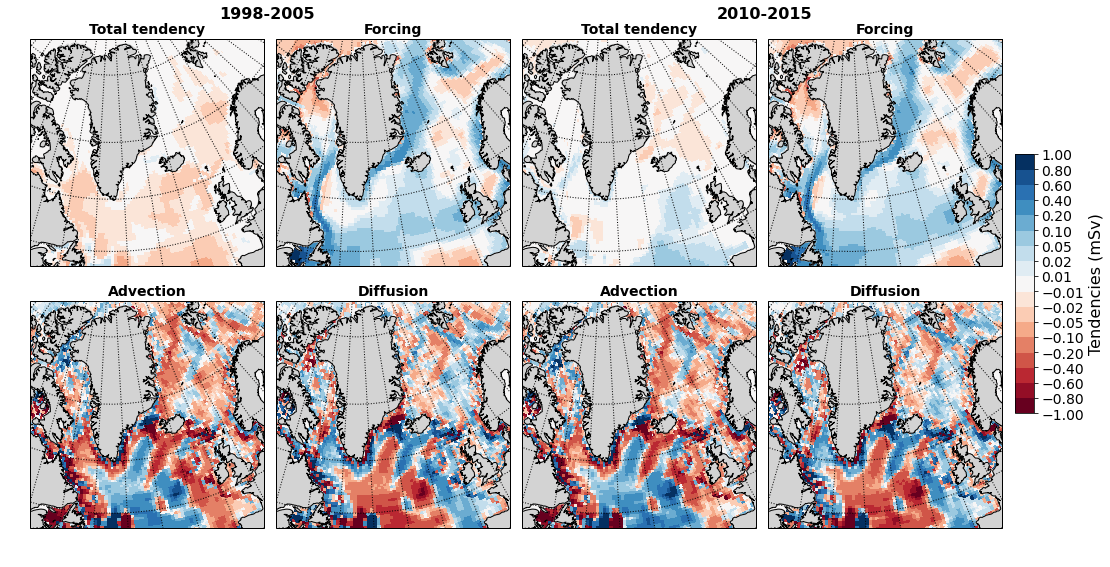

In [25]:
fig, row_axes = plt.subplots(figsize=(18,9), nrows=1, ncols=2, sharex=True)
fig.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, hspace=0.02, wspace = 0.05)

row_axes[0].set_title('1998-2005', fontsize=16, fontweight='bold')
row_axes[0].tick_params(axis='both',labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
row_axes[0]._frameon = False

ax11 = fig.add_subplot(2,4,1,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax11.set_title(r'Total tendency', fontsize=14, fontweight='bold')
ax11.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax11.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax11.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax11.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax11.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(tnd9805_reg),
                    cmap='RdBu', vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax12 = fig.add_subplot(2,4,2,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax12.set_title(r'Forcing', fontsize=14, fontweight='bold')
ax12.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax12.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax12.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax12.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax12.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(frc9805_reg),
                    cmap='RdBu', vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax21 = fig.add_subplot(2,4,5,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax21.set_title(r'Advection', fontsize=14, fontweight='bold')
ax21.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax21.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax21.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax21.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax21.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(adv9805_reg),
                    cmap='RdBu', vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax22 = fig.add_subplot(2,4,6,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax22.set_title(r'Diffusion', fontsize=14, fontweight='bold')
ax22.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax22.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax22.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax22.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax22.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(dif9805_reg),
                    cmap='RdBu', vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

row_axes[1].set_title('2010-2015', fontsize=16, fontweight='bold')
row_axes[1].tick_params(labelcolor=(1.,1.,1., 0.0), color=(1.,1.,1., 0.0),
                        top='off', bottom='off', left='off', right='off')
row_axes[1]._frameon = False

ax13 = fig.add_subplot(2,4,3,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax13.set_title(r'Total tendency', fontsize=14, fontweight='bold')
ax13.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax13.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax13.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax13.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax13.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(tnd1017_reg),
                    cmap='RdBu',vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax14 = fig.add_subplot(2,4,4,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax14.set_title(r'Forcing', fontsize=14, fontweight='bold')
ax14.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax14.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax14.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax14.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax14.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(frc1017_reg),
                    cmap='RdBu', vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax23 = fig.add_subplot(2,4,7,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax23.set_title(r'Advection', fontsize=14, fontweight='bold')
ax23.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax23.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax23.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax23.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax23.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(adv1017_reg),
                    cmap='RdBu',vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

ax24 = fig.add_subplot(2,4,8,projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0))
ax24.set_title(r'Diffusion', fontsize=14, fontweight='bold')
ax24.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax24.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax24.coastlines(resolution='50m',linewidth=1.0,zorder=2)
gl = ax24.gridlines(cartopy.crs.PlateCarree(), draw_labels=False, linewidth=1.0, linestyle=':', color='k')
gl.xlocator = mticker.FixedLocator(np.arange(-120,60,10))
gl.ylocator = mticker.FixedLocator(np.arange(0,100,10))
p = ax24.pcolormesh(new_grid_lon, new_grid_lat,np.ma.masked_invalid(dif1017_reg),
                    cmap='RdBu',vmin=-1, vmax=1, norm=norm, transform=cartopy.crs.PlateCarree())

cax = fig.add_axes([0.86, 0.30, 0.015, 0.4])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.9, ticks=ticks)
cb.set_label(r'Tendencies (mSv)',fontsize=16)
cb.ax.tick_params(labelsize=14)

plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps', rasterized=True, dpi=300)
#plt.savefig('/mnt/efs/figure.pdf', rasterized=True, dpi=300)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1026: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


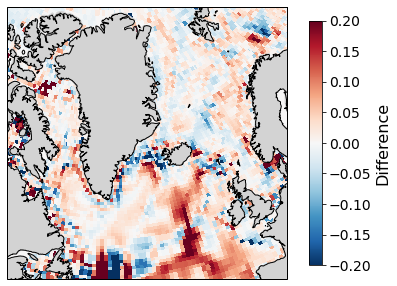

In [23]:
fig = plt.figure(figsize=(8,5))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0, 
                                                      false_easting=0.0, false_northing=0.0, globe=None))
ax.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax.coastlines(resolution='50m',linewidth=1.0,zorder=2)
p = ax.pcolormesh(new_grid_lon, new_grid_lat, np.ma.masked_invalid(adv1017_reg-adv9805_reg),
                  cmap='RdBu_r', vmin=-0.2, vmax=0.2, transform=cartopy.crs.PlateCarree())
cb = fig.colorbar(p, ticks=np.arange(-0.2,0.25,0.05), orientation='vertical', shrink=0.9)
cb.set_label(r'Difference',fontsize=16)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
plt.show()

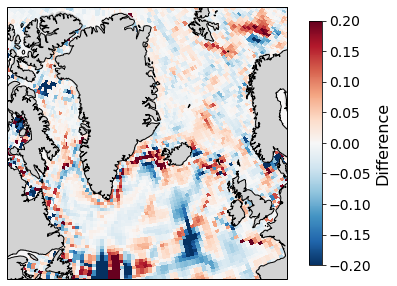

In [24]:
fig = plt.figure(figsize=(8,5))

ax = plt.axes(projection=cartopy.crs.LambertConformal(central_longitude=-45.0,central_latitude=50.0, 
                                                      false_easting=0.0, false_northing=0.0, globe=None))
ax.set_extent([-68, 0, 45, 83], cartopy.crs.Geodetic())
ax.add_feature(cartopy.feature.LAND,color='lightgrey',zorder=1)
ax.coastlines(resolution='50m',linewidth=1.0,zorder=2)
p = ax.pcolormesh(new_grid_lon, new_grid_lat, np.ma.masked_invalid(dif1017_reg-dif9805_reg),
                  cmap='RdBu_r', vmin=-0.2, vmax=0.2, transform=cartopy.crs.PlateCarree())
cb = fig.colorbar(p, ticks=np.arange(-0.2,0.25,0.05), orientation='vertical', shrink=0.9)
cb.set_label(r'Difference',fontsize=16)
cb.ax.tick_params(labelsize=14)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
plt.show()